## Setup and Imports

In [1]:
!pip install -qq --upgrade diffusers
!pip install -qq git+https://github.com/huggingface/transformers.git@main
!pip install -q bitsandbytes==0.41.3 accelerate==0.25.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 11.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.6/92.6 MB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 26.2 MB/s eta 0:00:00


In [2]:
import numpy as np
import requests
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import torch

from transformers import AutoModelForCausalLM, AutoTokenizer
from transformers import BlipProcessor, BlipForConditionalGeneration
from transformers import SamModel, SamProcessor
from transformers import OwlViTProcessor, OwlViTForObjectDetection, Owlv2Processor, Owlv2ForObjectDetection
from diffusers import AutoPipelineForInpainting
from transformers import AutoProcessor, LlavaForConditionalGeneration
from transformers import BitsAndBytesConfig
from transformers import pipeline

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

## Load the image and the text prompt

In [4]:
image_url = "https://i.imgur.com/qrN1OzK.jpeg"
raw_image = Image.open(
    requests.get(image_url, stream=True).raw
).convert("RGB")

image = raw_image.resize((512, 512))
edit_prompt = "replace the bridge with chocolates"

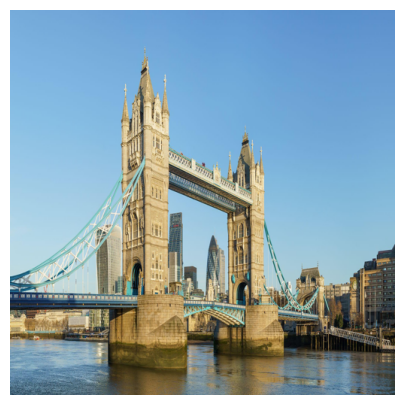

In [5]:
plt.figure(figsize=(5, 5))
plt.imshow(image)
plt.axis("off")
plt.show()

## Extract the objects from the prompt

In [6]:
language_model_id = "Qwen/Qwen1.5-0.5B-Chat"
language_model = AutoModelForCausalLM.from_pretrained(
    language_model_id,
    device_map="auto"
)
tokenizer = AutoTokenizer.from_pretrained(language_model_id)

config.json:   0%|          | 0.00/661 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.24G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/180 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [7]:
messages = [
  {"role": "system", "content": "Follow the examples and return the expected output"},
  {"role": "user", "content": "swap mountain and lion"},  # example 1
  {"role": "assistant", "content": "mountain, lion"},  # example 1
  {"role": "user", "content": "change the dog with cat"},  # example 2
  {"role": "assistant", "content": "dog, cat"},  # example 2
  {"role": "user", "content": "change the cat with a dog"},  # example 3
  {"role": "assistant", "content": "cat, dog"},  # example 3
  {"role": "user", "content": "replace the human with a boat"},  # example 4
  {"role": "assistant", "content": "human, boat"},  # example 4
  {"role": "user", "content": "in the above example change the background to the alps"},  # example 5
  {"role": "assistant", "content": "background, alps"},  # example 5
  {"role": "user", "content": "edit the house into a mansion"},  # example 6
  {"role": "assistant", "content": "house, a mansion"},  # example 6
  {"role": "user", "content": edit_prompt}
]
text = tokenizer.apply_chat_template(
  messages,
  tokenize=False,
  add_generation_prompt=True
)
model_inputs = tokenizer([text], return_tensors="pt").to(device)

with torch.no_grad():
  generated_ids = language_model.generate(
    model_inputs.input_ids,
    max_new_tokens=512,
    temperature=0.0,
    do_sample=False
  )

  generated_ids = [
    output_ids[len(input_ids):] for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids)
  ]

response = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:406: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:411: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.8` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


In [8]:
response

'bridge, chocolates'

In [9]:
to_replace, replace_with = response.split(", ")

In [10]:
print(f"{to_replace=}")
print(f"{replace_with=}")

to_replace='bridge'
replace_with='chocolates'


In [11]:
language_model.to("cpu")
del language_model
torch.cuda.empty_cache()

## Caption the image

In [ ]:
# caption_model_id = "Salesforce/blip-image-captioning-base"
# caption_model = BlipForConditionalGeneration.from_pretrained(caption_model_id).to(device)
# caption_processor = BlipProcessor.from_pretrained(caption_model_id)

In [14]:
# inputs = caption_processor(image, return_tensors="pt").to(device)
# with torch.no_grad():
#     outputs = caption_model.generate(**inputs, max_new_tokens=200)

# caption = caption_processor.decode(outputs[0], skip_special_tokens=True)

In [12]:
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16
)

In [13]:
model_id = "llava-hf/llava-1.5-7b-hf"

pipe = pipeline("image-to-text", model=model_id, model_kwargs={"quantization_config": quantization_config})

config.json:   0%|          | 0.00/950 [00:00<?, ?B/s]

`low_cpu_mem_usage` was None, now set to True since model is quantized.


model.safetensors.index.json:   0%|          | 0.00/70.1k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/4.96G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.18G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/141 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.33k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/41.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/438 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


preprocessor_config.json:   0%|          | 0.00/557 [00:00<?, ?B/s]

In [14]:
max_new_tokens = 200
prompt = "USER: <image>\nWhat is happening in this image?\nASSISTANT:"

outputs = pipe(image, prompt=prompt, generate_kwargs={"max_new_tokens": 200})

In [15]:
captioner_output = outputs[0]["generated_text"]

In [16]:
captioner_output

'USER:  \nWhat is happening in this image?\nASSISTANT: In the image, there is a large bridge with a clock tower on it, overlooking a city. The bridge is a prominent feature in the scene, and it appears to be a sunny day. The clock tower is located near the center of the bridge, and the cityscape can be seen in the background. The overall atmosphere of the image suggests a bustling urban environment with a mix of historical and modern elements.'

In [17]:
assistant_start = captioner_output.find("ASSISTANT:")

# Extract the substring starting from the index after "ASSISTANT:"
caption = captioner_output[assistant_start + len("ASSISTANT:"):]

In [18]:
caption

' In the image, there is a large bridge with a clock tower on it, overlooking a city. The bridge is a prominent feature in the scene, and it appears to be a sunny day. The clock tower is located near the center of the bridge, and the cityscape can be seen in the background. The overall atmosphere of the image suggests a bustling urban environment with a mix of historical and modern elements.'

In [19]:
replace_caption = caption.replace(to_replace, replace_with)

In [20]:
print(f"{caption=}")
print(f"{replace_caption=}")

caption=' In the image, there is a large bridge with a clock tower on it, overlooking a city. The bridge is a prominent feature in the scene, and it appears to be a sunny day. The clock tower is located near the center of the bridge, and the cityscape can be seen in the background. The overall atmosphere of the image suggests a bustling urban environment with a mix of historical and modern elements.'
replace_caption=' In the image, there is a large chocolates with a clock tower on it, overlooking a city. The chocolates is a prominent feature in the scene, and it appears to be a sunny day. The clock tower is located near the center of the chocolates, and the cityscape can be seen in the background. The overall atmosphere of the image suggests a bustling urban environment with a mix of historical and modern elements.'


In [ ]:
pipe.to("cpu")
del pipe
torch.cuda.empty_cache()

## Build segmentation mask for inpainting

### OWL ViT

In [23]:
owl_v2_model_id = "google/owlv2-base-patch16-ensemble"
processor = Owlv2Processor.from_pretrained(owl_v2_model_id)
od_model = Owlv2ForObjectDetection.from_pretrained(owl_v2_model_id).to(device)
text_queries = [to_replace]
inputs = processor(text=text_queries, images=image, return_tensors="pt").to(device)

with torch.no_grad():
    outputs = od_model(**inputs)
    target_sizes = torch.tensor([image.size]).to(device)
    results = processor.post_process_object_detection(
        outputs, threshold=0.1, target_sizes=target_sizes
    )[0]

boxes = results["boxes"].tolist()

preprocessor_config.json:   0%|          | 0.00/425 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.10k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/67.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/121 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/620M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


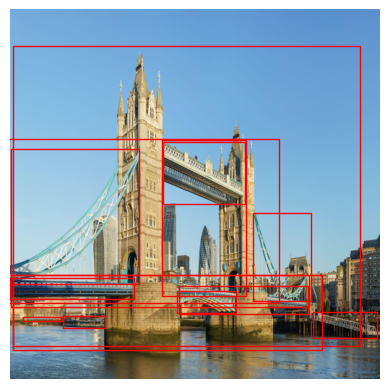

In [24]:
fig, ax = plt.subplots()
ax.imshow(image)

for box in boxes:
    x_min, y_min, x_max, y_max = box
    rect = patches.Rectangle(
        (x_min, y_min),
        x_max - x_min,
        y_max - y_min,
        linewidth=1,
        edgecolor="r",
        facecolor="none"
    )
    ax.add_patch(rect)

plt.axis("off")
plt.show()

In [25]:
od_model.to("cpu")
del od_model
torch.cuda.empty_cache()

### SAM

In [26]:
# SAM for image segmentation
sam_model_id = "facebook/sam-vit-base"
seg_model = SamModel.from_pretrained(sam_model_id).to(device)
processor = SamProcessor.from_pretrained(sam_model_id)

config.json:   0%|          | 0.00/6.57k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/375M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

In [27]:
input_boxes = [boxes]
inputs = processor(image, input_boxes=input_boxes, return_tensors="pt").to(device)

with torch.no_grad():
    outputs = seg_model(**inputs)

masks = processor.image_processor.post_process_masks(
    outputs.pred_masks.cpu(),
    inputs["original_sizes"].cpu(),
    inputs["reshaped_input_sizes"].cpu(),
)[0]

In [28]:
masks = torch.max(masks[:, 0, ...], dim=0, keepdim=False).values
masks.shape

torch.Size([512, 512])

In [29]:
seg_mask = Image.fromarray(masks.numpy())

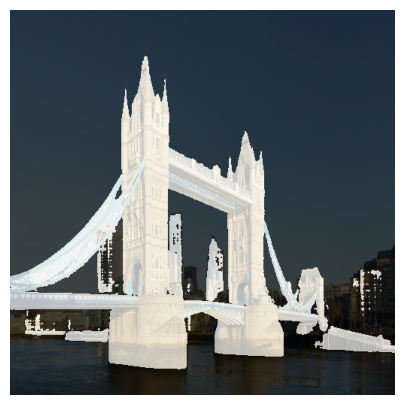

In [30]:
plt.figure(figsize=(5, 5))
plt.imshow(image)
plt.imshow(seg_mask, alpha=0.7, cmap="gray")
plt.axis("off")
plt.show()

In [31]:
seg_model.to("cpu")
del seg_model
torch.cuda.empty_cache()

## Output Image

### Inpain the image

In [32]:
pipeline = AutoPipelineForInpainting.from_pretrained(
    "diffusers/stable-diffusion-xl-1.0-inpainting-0.1",
    torch_dtype=torch.float16,
    variant="fp16",
).to(device)

model_index.json:   0%|          | 0.00/690 [00:00<?, ?B/s]

Fetching 18 files:   0%|          | 0/18 [00:00<?, ?it/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/746 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/479 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/737 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

text_encoder_2/config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/1.39G [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer_2/tokenizer_config.json:   0%|          | 0.00/725 [00:00<?, ?B/s]

tokenizer_2/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/1.93k [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

tokenizer_2/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/659 [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/5.14G [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

The config attributes {'decay': 0.9999, 'inv_gamma': 1.0, 'min_decay': 0.0, 'optimization_step': 37000, 'power': 0.6666666666666666, 'update_after_step': 0, 'use_ema_warmup': False} were passed to UNet2DConditionModel, but are not expected and will be ignored. Please verify your config.json configuration file.


In [33]:
prompt = replace_caption

negative_prompt = """lowres, bad anatomy, bad hands,
text, error, missing fingers, extra digit, fewer digits,
cropped, worst quality, low quality"""

output = pipeline(
    prompt=prompt,
    image=image,
    mask_image=seg_mask,
    negative_prompt=negative_prompt,
    guidance_scale=7.5,
    strength=1.0
).images[0]

Token indices sequence length is longer than the specified maximum sequence length for this model (84 > 77). Running this sequence through the model will result in indexing errors
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['mix of historical and modern elements.']
Token indices sequence length is longer than the specified maximum sequence length for this model (84 > 77). Running this sequence through the model will result in indexing errors
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['mix of historical and modern elements.']


  0%|          | 0/50 [00:00<?, ?it/s]

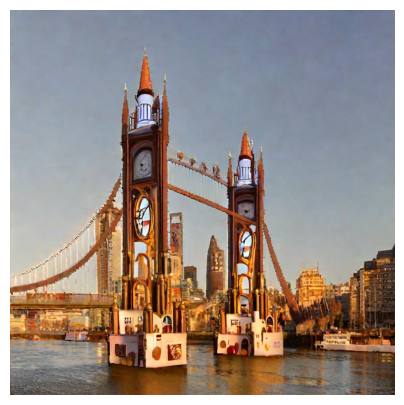

In [34]:
plt.figure(figsize=(5, 5))
plt.imshow(output)
plt.axis("off")
plt.show()

In [35]:
pipeline.to("cpu")
del pipeline
torch.cuda.empty_cache()

Pipelines loaded with `dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipeline in inference, due to the lack of support for`float16` operations on this device in PyTorch. Please, remove the `torch_dtype=torch.float16` argument, or use another device for inference.
Pipelines loaded with `dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipeline in inference, due to the lack of support for`float16` operations on this device in PyTorch. Please, remove the `torch_dtype=torch.float16` argument, or use another device for inference.
Pipelines loaded with `dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipeline in inference, du